# 8. XGBoost

**Import packages**

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

**Set directories**

In [3]:
print(os.getcwd())
dirRawData = "../RawData/"
dirPData = "../PData/"
dirPOutput = "../POutput/"

C:\Users\munch\Documents\Cass MSc\Term 3\Machine Learning\Coursework\PCode


**Load data**

In [4]:
f_name = dirPData + '02_df.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
df_all_onehot = dict_['df_all_onehot']

del f_name, dict_


f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
vars_ind_num = dict_['vars_ind_num']
var_dep = dict_['var_dep']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del f_name, dict_

**Prepare variables**

In [5]:
vars_ind = vars_ind_num + vars_ind_onehot #combine all 
idx_train  = np.where(df_all_onehot['fold'].isin(np.arange(0,8)))[0] #[0,1,2,3,4,5,6,7]
idx_val    = np.where(df_all_onehot['fold'].isin([8,9]))[0] #[8,9]
idx_design = np.where(df_all_onehot['fold'].isin(np.arange(0,10)))[0] #[0,1,2,3,4,5,6,7,8,9]
idx_test = np.where(df_all_onehot['fold'].isin([10]))[0]

In [6]:
#prepare x and y data
x = df_all_onehot[vars_ind].values
y = df_all_onehot[var_dep].values

y_train = y[idx_train]
y_val = y[idx_val]
y_design = y[idx_design]

In [7]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
standardScaler_ = StandardScaler()
standardScaler_.fit(x[idx_train])

X_train = standardScaler_.transform(x[idx_train])
X_val   = standardScaler_.transform(x[idx_val])
X_test = standardScaler_.transform(x[idx_test])
X_design = standardScaler_.transform(x[idx_design])

**Xgboost**

parameters explanation:
https://xgboost.readthedocs.io/en/latest/parameter.html

In [8]:
import xgboost as xgb
xgb_ = xgb.XGBClassifier()

xgb_.fit(X=X_train, y = np.ravel(y_train)) # fit model to train data with default settings

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
# prediction (probabilities)
xgb__pred_train_prob = xgb_.predict_proba(X_train)
xgb__pred_val_prob   = xgb_.predict_proba(X_val)
xgb__pred_test_prob = xgb_.predict_proba(X_test)

#prediction (0 or 1 output)
xgb__pred_train = xgb_.predict(X_train)
xgb__pred_val   = xgb_.predict(X_val)
xgb__pred_test = xgb_.predict(X_test)

In [10]:
#print accuracy of the training and validation
train_score = xgb_.score(X_train,y_train)
val_score = xgb_.score(X_val, y_val)
print("train score is {}".format(train_score))
print("val score is {}".format(val_score))

train score is 0.9338120512019982
val score is 0.9294517637059073


In [12]:
#print roc_auc_score
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_train,xgb__pred_train)
auc_val = roc_auc_score(y_val,xgb__pred_val)
print("train auc: {}".format(auc_train))
print("val auc: {}".format(auc_val))

train auc: 0.6559677654769918
val auc: 0.6436899503217941


In [13]:
#save baseline xgboost
import csv
f_name = dirPOutput + 'baslinexgboost.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], xgb__pred_test_prob[:,1]))

This baseline xgboost received a Kaggle score of 0.87376

In [14]:
#kfold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)

from sklearn.model_selection import cross_val_score
result_roc_auc = cross_val_score(xgb_, X_design, np.ravel(y_design), cv=kf, scoring='roc_auc')
result_accuracy = cross_val_score(xgb_, X_design, np.ravel(y_design), cv=kf, scoring='accuracy')
print("average score using 10 fold cross validation on design data: {}".format(result_accuracy.mean()))
print("average roc_auc score using 10 fold cross validation on design data: {}".format(result_roc_auc.mean()))

average score using 10 fold cross validation on design data: 0.921920534334722
average roc_auc score using 10 fold cross validation on design data: 0.8713212038661784


**Grid search: tuning hyperparameters using sklearn GridSearchCV**

Tune parameters min_child_weight, gamma, max_depth

Run time is long..

In [15]:
from sklearn.model_selection import GridSearchCV

#tune max depth
max_depth = [1,2,3,4,5,6,7,8,9,10]
param_grid = dict(max_depth = max_depth)
xgb_ = xgb.XGBClassifier()
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, cv = 10, n_jobs=-1,scoring='roc_auc')
#cv = number of folds for validation

In [16]:
#fit using best parameters
grid_result = grid.fit(X_design,np.ravel(y_design))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Summarize results

Best: 0.872826 using {'max_depth': 4}


In [30]:
#tune gamma
gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(gamma = gamma)
xgb_ = xgb.XGBClassifier(max_depth=4)
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, cv = 10, n_jobs=-1,scoring='roc_auc')
#cv = number of folds for validation
grid_result = grid.fit(X_design,np.ravel(y_design))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Summarize results

Best: 0.872826 using {'gamma': 0.0}


In [31]:
#use optimized logistic regression to predict test data
xgbopt3_= grid.predict(X_test)
xgbopt3_prob = grid.predict_proba(X_test)

In [22]:
#tune min_child_weight
min_child_weight = range(1,6,2)
param_grid = dict(min_child_weight = min_child_weight)
xgb_ = xgb.XGBClassifier(max_depth=4,gamma=0)
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, cv = 10, n_jobs=-1,scoring='roc_auc')
#cv = number of folds for validation
grid_result = grid.fit(X_design,np.ravel(y_design))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Summarize results

Best: 0.873310 using {'min_child_weight': 3}


In [23]:
#predict test data
xgbopt_= grid.predict(X_test)
xgbopt_prob = grid.predict_proba(X_test)

After tuning max_depth, gamma and min_child_weight separately(due to computing time), the submission resulted in an increase in auc score to 0.8733310, and kaggle score of 0.87807

In [27]:
#tune all 3 parameters simultaneously
min_child_weight = [1,3,5,7]
gamma = [0,1,2,3]
max_depth=[3,4,5]
param_grid = dict(gamma = gamma, min_child_weight = min_child_weight, max_depth=max_depth)
xgb_ = xgb.XGBClassifier()
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, cv = 10, n_jobs=-1,scoring='roc_auc')
#cv = number of folds for validation
grid_result = grid.fit(X_design,np.ravel(y_design))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Summarize results

Best: 0.874784 using {'gamma': 3, 'max_depth': 5, 'min_child_weight': 7}


In [28]:
#use optimized logistic regression to predict test data
xgbopt2_= grid.predict(X_test)
xgbopt2_prob = grid.predict_proba(X_test)

After trying grid search for all 3 parameters in the above loop, auc improved again however the kaggle score did not improve and was only 0.87502

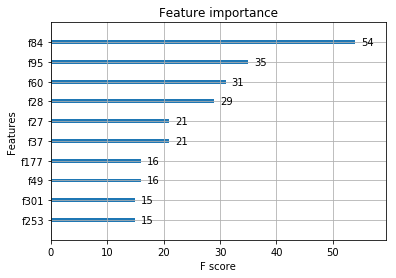

In [24]:
#Show feature importance
from xgboost import plot_importance
xgb_best = xgb.XGBClassifier(gamma = 3,max_deph = 5, min_child_weight = 7)
xgb_best.fit(X_design,np.ravel(y_design))

import matplotlib.pyplot as plt
from matplotlib import pyplot
plot_importance(xgb_best, max_num_features=10) # top 10 most important features
plt.show()

**Save prediction**

In [25]:
import csv
f_name = dirPOutput + 'optimizexgboost.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], xgbopt_prob[:,1]))

In [26]:
#save data
xgbopt_prob_design = grid.predict_proba(X_design)

dict_ = {'xgbopt_prob': xgbopt_prob_design,
        'xgbopt_prob_test' : xgbopt_prob}

f_name = dirPData + 'xgb.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name

In [29]:
#save prediction 2
import csv
f_name = dirPOutput + 'optimizexgboost2.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], xgbopt2_prob[:,1]))

In [32]:
#save prediction 3
import csv
f_name = dirPOutput + 'optimizexgboost3.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], xgbopt3_prob[:,1]))